In [17]:
from exojax.atm import amclouds
import jax.numpy as jnp

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# dynamic viscosity in H2 atmosphere (cm/g/s)
T=np.logspace(np.log10(100),np.log10(3000))
eta=amclouds.eta_H2_Rosner(T)

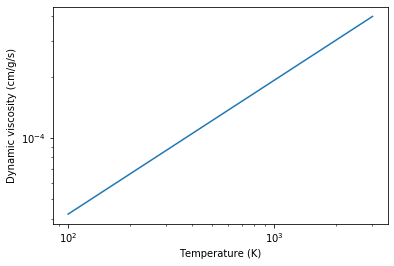

In [7]:
plt.plot(T,eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()

In [2]:
#CIA
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(9500,30000,1000,unit="AA")
from exojax.spec import contdb
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

nugrid is log: mode= lpf
H2-H2


In [67]:
from exojax.spec import rtransfer as rt
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
alpha=0.097
T0=1500.
Tarr=T0*(Parr)**alpha

In [68]:
#MgSiO3 (enstatite) clouds
from exojax.atm.psat import Psat_enstatite
P_enstatite=Psat_enstatite(Tarr)

def Psat_Fe_liquid(T):
    return jnp.exp(9.86-37120./T)

P_fe_liq=Psat_Fe_liquid(Tarr)

def Psat_Fe_solid(T):
    return jnp.exp(15.71-47664./T)

P_fe_sol=Psat_Fe_solid(Tarr)

In [69]:
def MgSiO3(temp, mh = 1 ):
    """Computes vapor pressure curve
    
    Parameters 
    ----------
    temp : float, ndarray 
        Temperature (K)
    mh : float 
        NON log metallicity relative to solar (1=1Xsolar)
    Returns
    -------
    vapor pressure in dyne/cm^2
    """
    mh = np.log10(mh)
    #MgSiO3 vapor pressure above cloud
    #the one that is in A&M is this : np.exp(-58663./temp + 25.37)
    #this is a new one from Channon Visscher
    pvap_mgsio3 = 10.0**(11.83 - 27250.0/temp - mh)
#    #convert bars -> dynes/cm^2
#    pvap_mgsio3 = 1e6 * pvap_mgsio3 
    return pvap_mgsio3

In [70]:
# from Virga
def Psat_enstatite_new(T):
    return 10.0**(11.83 - 27250.0/T - 1.0)

P_enstatite_new=Psat_enstatite_new(Tarr)

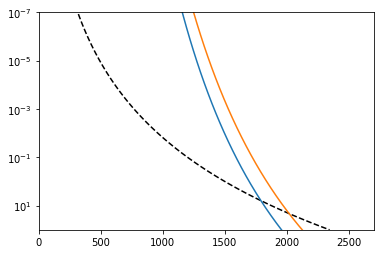

In [79]:
VMR=0.0001
import matplotlib.pyplot as plt
plt.plot(Tarr,Parr,color="black",ls="dashed")
plt.plot(Tarr,P_enstatite/VMR)
plt.plot(Tarr,P_enstatite_new/VMR)
#plt.plot(Tarr,P_fe_liq)
#plt.plot(Tarr,P_fe_sol)
plt.yscale("log")
plt.ylim(100,1.e-7)
plt.xlim(0,2700)
plt.gca().invert_yaxis()
plt.show()

In [43]:
Psat_enstatite(1500)

DeviceArray(1.0798735e-06, dtype=float32)